In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import MultinomialNB


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

import os

In [3]:
data = pd.read_csv("Spam_SMS.csv")
data.head()

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data.describe()

,Class,Message
count,5574,5574
unique,2,5159
top,ham,"Sorry, I'll call later"
freq,4827,30


In [5]:
data = data.rename(columns={"Class":"label", "Message":"text"})

In [6]:
data.groupby("label").describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4827   4518                             Sorry, I'll call later   30
spam    747    641  Please call our customer service representativ...    4

In [7]:
data.label.value_counts()

label
ham     4827
spam     747
Name: count, dtype: int64

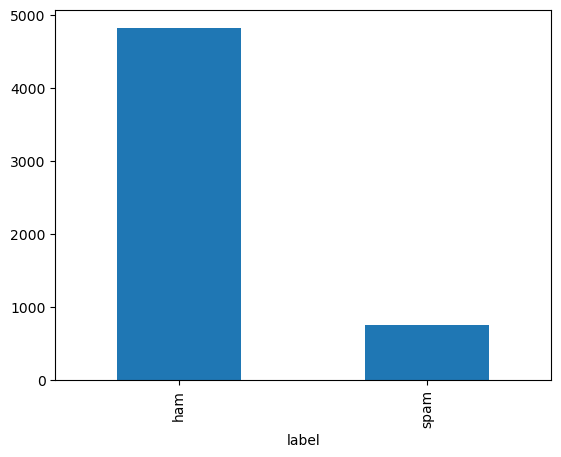

In [8]:
data.label.value_counts().plot.bar();

In [9]:
data['spam'] = data['label'].map( {'spam': 1, 'ham': 0} ).astype(int)
data.head(10)

,label,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


In [10]:
data['length'] = data['text'].apply(len)
data.head(10)

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1,147
6,ham,Even my brother is not like to speak with me. ...,0,77
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0,160
8,spam,WINNER!! As a valued network customer you have...,1,157
9,spam,Had your mobile 11 months or more? U R entitle...,1,154


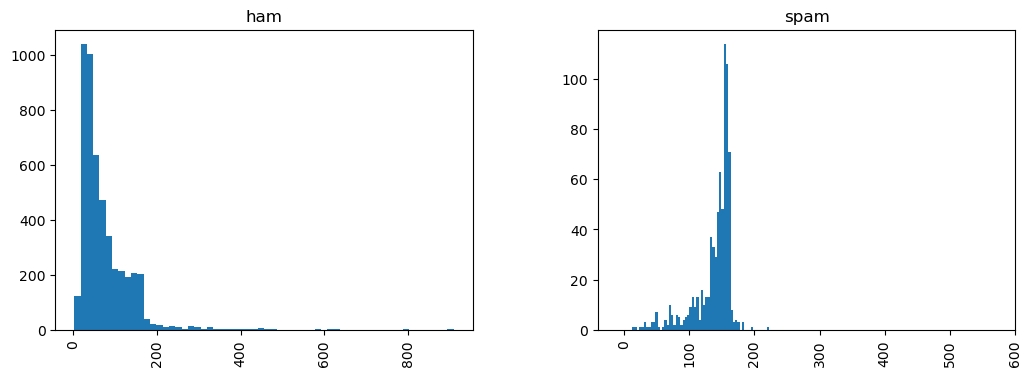

In [11]:
data.hist(column='length',by='label',bins=60,figsize=(12,4));
plt.xlim(-40,600);

In [12]:
data_ham  = data[data['spam'] == 0].copy()
data_spam = data[data['spam'] == 1].copy()

In [13]:
import string
string.punctuation
from nltk.corpus import stopwords
stopwords.words("english")[100:110]

['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']

In [14]:
def remove_punctuation_and_stopwords(sms):
    
    sms_no_punctuation = [ch for ch in sms if ch not in string.punctuation]
    sms_no_punctuation = "".join(sms_no_punctuation).split()
    
    sms_no_punctuation_no_stopwords = \
        [word.lower() for word in sms_no_punctuation if word.lower() not in stopwords.words("english")]
        
    return sms_no_punctuation_no_stopwords
    

In [15]:
data['text'].apply(remove_punctuation_and_stopwords).head(3)

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
Name: text, dtype: object

In [16]:
from collections import Counter

In [17]:
data_ham.loc[:, 'text'] = data_ham['text'].apply(remove_punctuation_and_stopwords)
words_data_ham = data_ham['text'].tolist()
data_spam.loc[:, 'text'] = data_spam['text'].apply(remove_punctuation_and_stopwords)
words_data_spam = data_spam['text'].tolist()

In [18]:
list_ham_words = []
for sublist in words_data_ham:
    for item in sublist:
        list_ham_words.append(item)
list_spam_words = []
for sublist in words_data_spam:
    for item in sublist:
        list_spam_words.append(item)       

In [19]:
c_ham  = Counter(list_ham_words)
c_spam = Counter(list_spam_words)
df_hamwords_top30  = pd.DataFrame(c_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30 = pd.DataFrame(c_spam.most_common(30), columns=['word', 'count'])

C:\Users\tejas\AppData\Local\Temp\ipykernel_11560\3077249696.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='word', y='count',


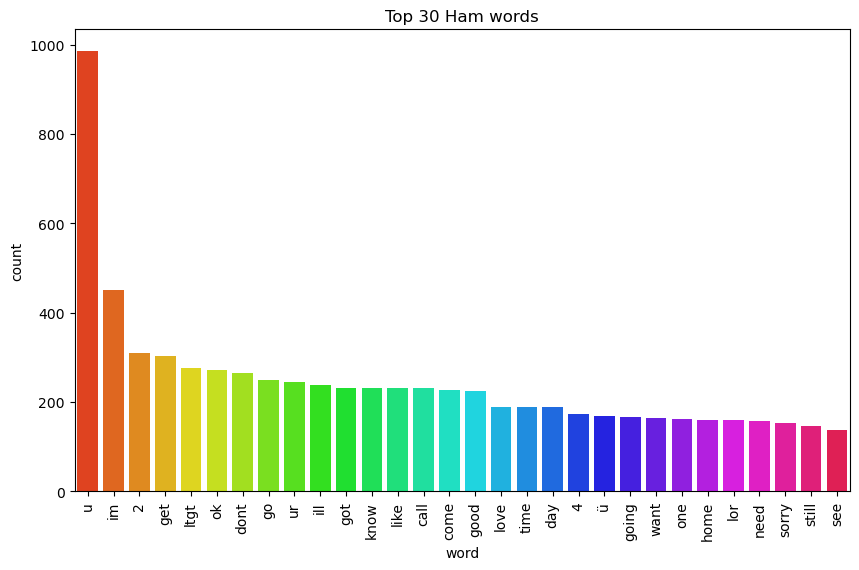

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30, ax=ax,palette=sns.color_palette("hsv", len(df_hamwords_top30)))
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

C:\Users\tejas\AppData\Local\Temp\ipykernel_11560\2788258725.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='word', y='count',


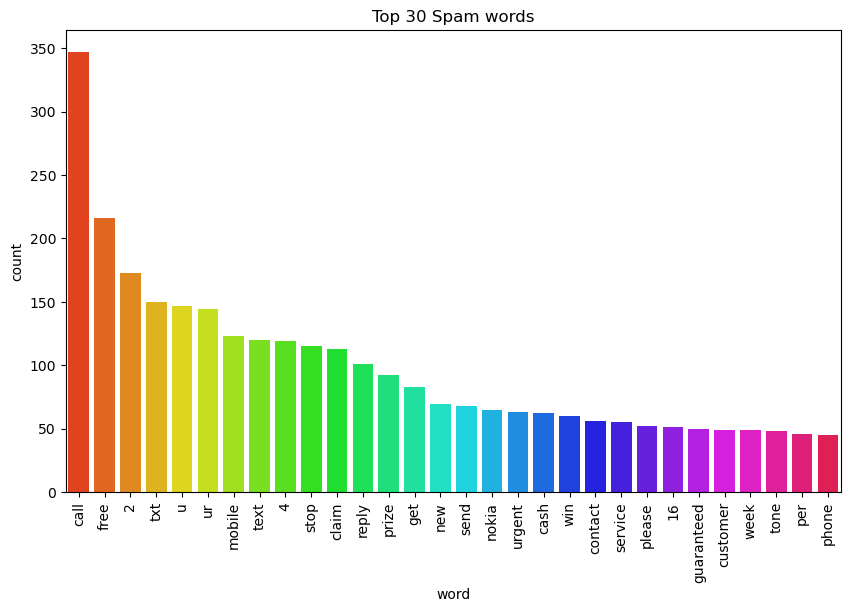

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30, ax=ax,palette=sns.color_palette("hsv", len(df_hamwords_top30)))
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

In [23]:
fdist_ham  = nltk.FreqDist(list_ham_words)
fdist_spam = nltk.FreqDist(list_spam_words)

In [24]:
df_hamwords_top30_nltk  = pd.DataFrame(fdist_ham.most_common(30),  columns=['word', 'count'])
df_spamwords_top30_nltk = pd.DataFrame(fdist_spam.most_common(30), columns=['word', 'count'])

C:\Users\tejas\AppData\Local\Temp\ipykernel_11560\674300920.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='word', y='count',


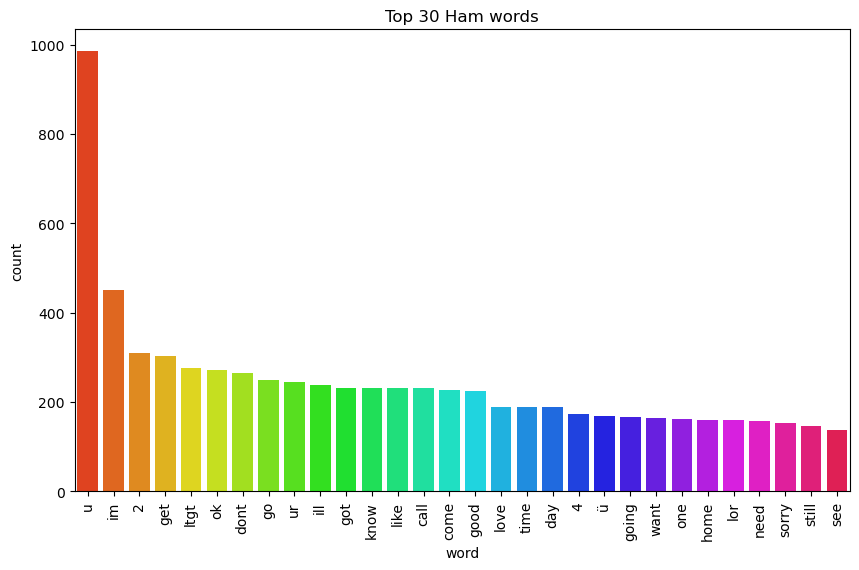

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_hamwords_top30_nltk, ax=ax,palette=sns.color_palette("hsv", len(df_hamwords_top30)))
plt.title("Top 30 Ham words")
plt.xticks(rotation='vertical');

C:\Users\tejas\AppData\Local\Temp\ipykernel_11560\1044267636.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='word', y='count',


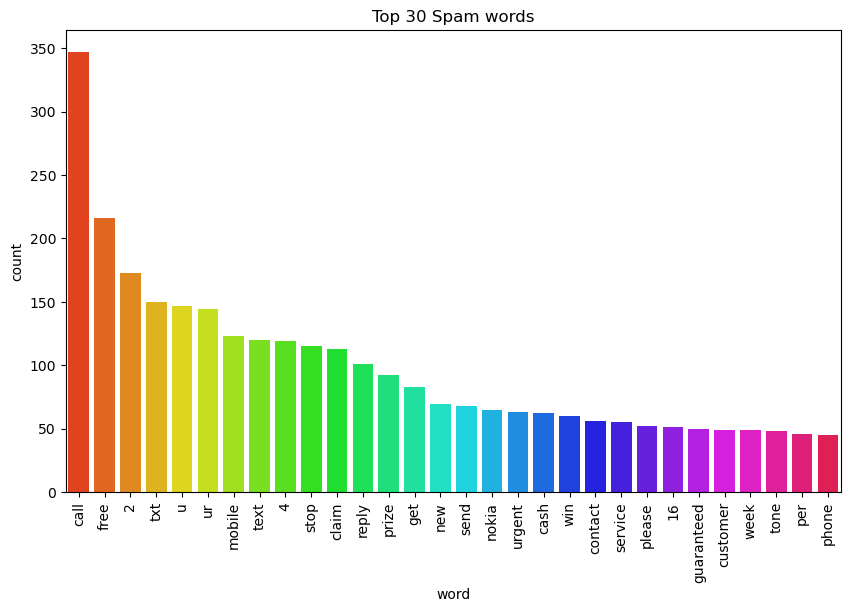

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=df_spamwords_top30_nltk, ax=ax,palette=sns.color_palette("hsv", len(df_hamwords_top30)))
plt.title("Top 30 Spam words")
plt.xticks(rotation='vertical');

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(data['text'])
sample_spam = data['text'][8]
bow_sample_spam = bow_transformer.transform([sample_spam])

In [28]:
sample_ham = data['text'][4]
bow_sample_ham = bow_transformer.transform([sample_ham])
print(sample_ham)
print(bow_sample_ham)

Nah I don't think he goes to usf, he lives around here though
  (0, 1293)	1
  (0, 2907)	1
  (0, 3800)	1
  (0, 5058)	1
  (0, 5691)	1
  (0, 8307)	1
  (0, 8326)	1
  (0, 8758)	1


In [29]:
bow_data = bow_transformer.transform(data['text'])

In [30]:
print( bow_data.nnz / (bow_data.shape[0] * bow_data.shape[1]) *100 )

0.09435773797860722


In [31]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(bow_data)
tfidf_sample_ham = tfidf_transformer.transform(bow_sample_ham)
print(tfidf_sample_ham)

  (0, 8758)	0.4002215411690469
  (0, 8326)	0.35477337772509704
  (0, 8307)	0.2666884016393785
  (0, 5691)	0.4050980486709611
  (0, 5058)	0.4492867325624261
  (0, 3800)	0.3568885148359025
  (0, 2907)	0.22849175416409648
  (0, 1293)	0.31192142285586666


In [32]:
tfidf_sample_spam = tfidf_transformer.transform(bow_sample_spam)
print(tfidf_sample_spam)

  (0, 9512)	0.2604704749562644
  (0, 9126)	0.23445410442468242
  (0, 8794)	0.24115538297703254
  (0, 8790)	0.22255196396602828
  (0, 7287)	0.21485018301001318
  (0, 7018)	0.256405203360391
  (0, 6847)	0.29432371435062715
  (0, 6607)	0.17890448987893473
  (0, 5767)	0.21485018301001318
  (0, 4811)	0.29432371435062715
  (0, 4238)	0.22555515434418869
  (0, 2554)	0.19150636249403208
  (0, 2267)	0.21371844502573412
  (0, 2206)	0.34064149340516364
  (0, 1927)	0.1152173145712974
  (0, 324)	0.23877409980487949
  (0, 218)	0.29432371435062715


In [33]:
data_tfidf = tfidf_transformer.transform(bow_data)


In [34]:
from sklearn.model_selection import train_test_split

data_tfidf_train, data_tfidf_test, label_train, label_test = \
    train_test_split(data_tfidf, data["spam"], test_size=0.2, random_state=5)

In [35]:
data_tfidf_train = data_tfidf_train.A
data_tfidf_test = data_tfidf_test.A

In [36]:
spam_detect_model = MultinomialNB().fit(data_tfidf_train, label_train)
pred_test_MNB = spam_detect_model.predict(data_tfidf_test)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
print(acc_MNB)

0.9641255605381166


In [37]:
scaler = MinMaxScaler()
data_tfidf_train_sc = scaler.fit_transform(data_tfidf_train)
data_tfidf_test_sc  = scaler.transform(data_tfidf_test)

In [38]:
spam_detect_model_minmax = MultinomialNB().fit(data_tfidf_train_sc, label_train)
pred_test_MNB = spam_detect_model_minmax.predict(data_tfidf_test_sc)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
print(acc_MNB)

0.9829596412556054


In [39]:
from sklearn.model_selection import train_test_split

sms_train, sms_test, label_train, label_test = \
    train_test_split(data["text"], data["spam"], test_size=0.2, random_state=5)

In [40]:
pipe_MNB = Pipeline([ ('bow'  , CountVectorizer(analyzer = remove_punctuation_and_stopwords) ),
                   ('tfidf'   , TfidfTransformer()),
                   ('clf_MNB' , MultinomialNB()),
                    ])

In [41]:
pipe_MNB.fit(X=sms_train, y=label_train)
pred_test_MNB = pipe_MNB.predict(sms_test)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
print(acc_MNB)
print(pipe_MNB.score(sms_test, label_test))

0.9668161434977578
0.9668161434977578


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
pipe_MNB_tfidfvec = Pipeline([ ('tfidf_vec' , TfidfVectorizer(analyzer = remove_punctuation_and_stopwords)),
                               ('clf_MNB'   , MultinomialNB()),
                            ])

In [43]:
pipe_MNB_tfidfvec.fit(X=sms_train, y=label_train)
pred_test_MNB_tfidfvec = pipe_MNB_tfidfvec.predict(sms_test)
acc_MNB_tfidfvec = accuracy_score(label_test, pred_test_MNB_tfidfvec)
print(acc_MNB_tfidfvec)
print(pipe_MNB_tfidfvec.score(sms_test, label_test))

0.9668161434977578
0.9668161434977578


In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

In [52]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5,  
                cmap="Blues", square=True, cbar=False)
    #  
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [53]:
list_clf = ["MNB"]

list_pred = [pred_test_MNB]

dict_pred = dict(zip(list_clf, list_pred))

In [54]:
def plot_all_confusion_matrices(y_true, dict_all_pred, str_title):
    
    list_classifiers = list(dict_all_pred.keys())
    plt.figure(figsize=(10,7.5))
    plt.suptitle(str_title, fontsize=20, fontweight='bold')
    n=231

    for clf in list_classifiers : 
        plt.subplot(n)
        plot_confusion_matrix(y_true, dict_all_pred[clf])
        plt.title(clf, fontweight='bold')
        n+=1

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    

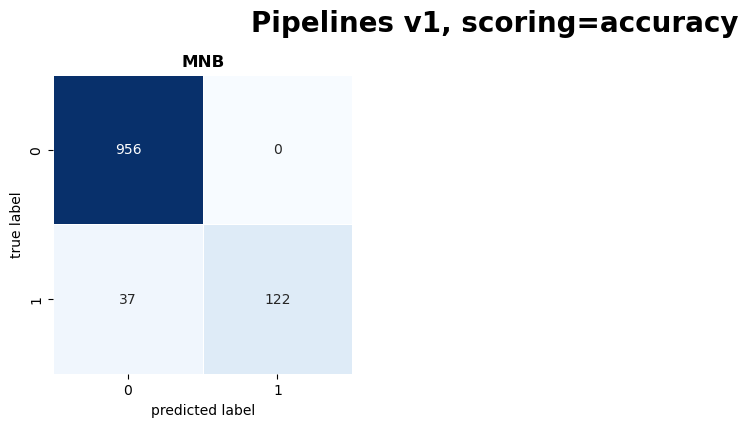

In [55]:
plot_all_confusion_matrices(label_test, dict_pred, "Pipelines v1, scoring=accuracy")

In [56]:
dict_acc = {}
for clf in list_clf :
    dict_acc[clf] = accuracy_score(label_test, dict_pred[clf])
for clf in list_clf :
    print(clf, " " , dict_acc[clf])

MNB   0.9668161434977578


In [57]:
for clf in list_clf :
    print(clf, " ", precision_score(label_test, dict_pred[clf]))
for clf in list_clf :
    print(clf, " ", precision_score(label_test, dict_pred[clf], average=None, labels=[0,1]))

MNB   1.0
MNB   [0.96273917 1.        ]


In [58]:
for clf in list_clf :
    print(clf, " ", recall_score(label_test, dict_pred[clf]))
for clf in list_clf :
    print(clf, " ", recall_score(label_test, dict_pred[clf], average=None, labels=[0,1] ))

MNB   0.7672955974842768
MNB   [1.        0.7672956]


In [59]:
for clf in list_clf :
    print(clf, " ", f1_score(label_test, dict_pred[clf], average=None, labels=[0,1] ))

MNB   [0.98101591 0.8683274 ]


In [63]:
import pickle

with open('message classifier model.pkl', 'wb') as file:
    pickle.dump(pipe_MNB, file)

print("Model exported suucessfully!")


Model exported suucessfully!
